In [1]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df_data2 = df.iloc[:, 1:7]

df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


> <h3> Extracting All Disease information from the Dataset </h3>

In [3]:
def search_keywords(data_frame, keyword):
    left_diagnosis = data_frame[data_frame['Left-Diagnostic Keywords'].str.contains(keyword)]['Left-Fundus'].values
    right_diagnosis = data_frame[data_frame['Right-Diagnostic Keywords'].str.contains(keyword)]['Right-Fundus'].values
    combined = np.concatenate((left_diagnosis, right_diagnosis))
    
    return combined

# Mencari semua kata kunci dalam satu langkah
image_arrays = {}

# Daftar kata kunci yang ingin dicari
keywords = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]  # Ganti dengan kata kunci yang diinginkan

for keyword in keywords:
    images_for_keyword = search_keywords(df_data2, keyword)
    image_arrays[keyword] = images_for_keyword

# Menampilkan jumlah gambar untuk setiap kata kunci
for keyword, images in image_arrays.items():
    print(f"Number of images for {keyword}: {len(images)}")

# Combine all images for normal and conditions
all_images = np.concatenate(list(image_arrays.values()), axis=0)
print("Total number of images:", len(all_images))

# Convert image arrays to dictionary
class_images_dict = {keyword: images.tolist() for keyword, images in image_arrays.items()}

Number of images for cataract: 594
Number of images for normal: 5683
Number of images for myopia: 479
Number of images for hypertensive: 382
Number of images for diabetic: 165
Number of images for age-related macular degeneration: 551
Number of images for glaucoma: 616
Total number of images: 8470


><h3>Creating Dataset from images (Oversample)</h3>

In [4]:
from imblearn.over_sampling import RandomOverSampler

IMG_SIZE = 224

def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
    non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
    img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
    img = cv2.resize(img, target_shape)
    return img

# Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
def gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Fungsi untuk melakukan histogram equalization pada gambar
def histogram_equalization(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Lakukan histogram equalization
    equalized = cv2.equalizeHist(gray)
    equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
    filtered = gaussian_blur(equalized)
    return filtered

# Fungsi untuk melakukan histogram equalization pada gambar
def clahe(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    enhanced_image = clahe.apply(gray)
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
    filtered = gaussian_blur(enhanced_image)
    return filtered

def create_dataset_with_oversampling(dataset_dir, class_images_dict, image_size=(224, 224)):
    dataset = []
    labels = list(class_images_dict.keys())

    for class_name, image_category in class_images_dict.items():
        for img in tqdm(image_category, desc=f"Processing {class_name} images"):
            image_path = os.path.join(dataset_dir, img)
            try:
                image = load_prep_img(image_path)
#                 image = histogram_equalization(image)
#                 image = clahe(image)
            except:
                continue

            # Assuming the class labels are encoded as integers
            label = np.array(labels.index(class_name))
            
            dataset.append([np.array(image), label])

    # Convert the dataset to a DataFrame
    df = pd.DataFrame(dataset, columns=['image', 'label'])

    # Convert labels to integers explicitly
    df['label'] = df['label'].astype(int)

    # Apply random oversampling
    oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = oversample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

    # Reconstruct the dataset
    resampled_dataset = [(X_resampled[i][0], y_resampled[i]) for i in range(len(X_resampled))]

    random.shuffle(resampled_dataset)

    # Print original class distribution
    print("Original Class Distribution:")
    for class_name in labels:
        class_count = df[df['label'] == labels.index(class_name)]['label'].count()
        print(f"{class_name}: {class_count}")

    # Print oversampled class distribution
    print("\nOversampled Class Distribution:")
    resampled_df = pd.DataFrame({'label': y_resampled})
    for class_name in labels:
        class_count = resampled_df[resampled_df['label'] == labels.index(class_name)]['label'].count()
        print(f"{class_name}: {class_count}")
    return resampled_dataset, labels

# Placeholder arrays, replace these with actual arrays when available
cataract = class_images_dict.get('cataract', [])
normal = class_images_dict.get('normal', [])
diabetic = class_images_dict.get('diabetic', [])
amd = class_images_dict.get('age-related macular degeneration', [])
glaucoma = class_images_dict.get('glaucoma', [])
myopia = class_images_dict.get('myopia', [])
hypertensive = class_images_dict.get('hypertensive', [])

# Assuming you have a dictionary of class images
class_images_dict = {
    'cataract': cataract,
    'normal': normal,
    'diabetic': diabetic,
    'age-related macular degeneration': amd,
    'glaucoma': glaucoma,
    'myopia': myopia,
    'hypertensive': hypertensive
}

# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/"
dataset, labels = create_dataset_with_oversampling(dataset_dir, class_images_dict)
print("Total number of images in the dataset:", len(dataset))

Processing diabetic images: 100%|██████████| 165/165 [00:14<00:00, 11.46it/s]
Processing age-related macular degeneration images: 100%|██████████| 551/551 [00:48<00:00, 11.41it/s]
Processing hypertensive images: 100%|██████████| 382/382 [00:33<00:00, 11.31it/s]


Original Class Distribution:
cataract: 594
normal: 5683
diabetic: 165
age-related macular degeneration: 551
glaucoma: 616
myopia: 479
hypertensive: 382

Oversampled Class Distribution:
cataract: 5683
normal: 5683
diabetic: 5683
age-related macular degeneration: 5683
glaucoma: 5683
myopia: 5683
hypertensive: 5683
Total number of images in the dataset: 39781


><h3>Creating Dataset from images (No Handling)</h3>

In [5]:
# IMG_SIZE = 224

# def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
#     non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
#     img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
#     img = cv2.resize(img, target_shape)
#     return img

# # Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
# def gaussian_blur(image, kernel_size=(5, 5)):
#     return cv2.GaussianBlur(image, kernel_size, 0)

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)
#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
#     filtered = gaussian_blur(equalized)
#     return filtered

# # Fungsi untuk melakukan histogram equalization pada gambar
# def clahe(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10,10))
#     enhanced_image = clahe.apply(gray)
#     enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
#     filtered = gaussian_blur(enhanced_image)
#     return filtered

# def create_dataset(dataset_dir, class_images_dict, image_size=(224, 224)):
#     dataset = []
#     labels = list(class_images_dict.keys())

#     for class_name, image_category in class_images_dict.items():
#         for img in tqdm(image_category, desc=f"Processing {class_name} images"):
#             image_path = os.path.join(dataset_dir, img)
#             try:
#                 image = load_prep_img(image_path)
# #                 image = histogram_equalization(image)
#                 image = clahe(image)
#             except:
#                 continue

#             # Assuming the class labels are encoded as integers
#             label = np.array(labels.index(class_name))
            
#             dataset.append([np.array(image), label])

#     random.shuffle(dataset)
#     return dataset, labels

# # Placeholder arrays, replace these with actual arrays when available
# cataract = class_images_dict.get('cataract', [])
# normal = class_images_dict.get('normal', [])
# diabetic = class_images_dict.get('diabetic', [])
# amd = class_images_dict.get('age-related macular degeneration', [])
# glaucoma = class_images_dict.get('glaucoma', [])
# myopia = class_images_dict.get('myopia', [])
# hypertensive = class_images_dict.get('hypertensive', [])

# # Assuming you have a dictionary of class images
# class_images_dict = {
#     'cataract': cataract,
#     'normal': normal,
#     'diabetic': diabetic,
#     'age-related macular degeneration': amd,
#     'glaucoma': glaucoma,
#     'myopia': myopia,
#     'hypertensive': hypertensive
# }

# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
# dataset, labels = create_dataset(dataset_dir, class_images_dict)
# print("Total number of images in the dataset:", len(dataset))

><h3>Creating Dataset from images (Undersample)</h3>

In [6]:
# from imblearn.under_sampling import RandomUnderSampler

# IMG_SIZE = 224

# def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
#     non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
#     img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
#     img = cv2.resize(img, target_shape)
#     return img

# def median_filter(image, kernel_size):
#     # Pastikan ukuran kernel ganjil
#     if kernel_size % 2 == 0:
#         kernel_size += 1

#     # Lakukan filter median
#     filtered_image = cv2.medianBlur(image, kernel_size)

#     return filtered_image

# # Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
# def gaussian_blur(image, kernel_size=(5, 5)):
#     return cv2.GaussianBlur(image, kernel_size, 0)

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)

#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
    
#     kernel_size = 5
    
#     filtered = gaussian_blur(equalized)
# #     filtered = median_filter(equalized, kernel_size)
# #     filtered = wiener_filter(equalized)

#     return filtered

# def create_dataset(dataset_dir, class_images_dict, image_size=(224, 224)):
#     dataset = []
#     labels = list(class_images_dict.keys())

#     for class_name, image_category in class_images_dict.items():
#         for img in tqdm(image_category, desc=f"Processing {class_name} images"):
#             image_path = os.path.join(dataset_dir, img)
#             try:
#                 image = load_prep_img(image_path)
#                 image = histogram_equalization(image)
#             except:
#                 continue

#             # Assuming the class labels are encoded as integers
#             label = np.array(labels.index(class_name))
            
#             dataset.append([np.array(image), label])

#     # Convert the dataset to a DataFrame
#     df = pd.DataFrame(dataset, columns=['image', 'label'])

# #     # Convert labels to integers explicitly
# #     df['label'] = df['label'].astype(int)

# # #     # Apply random oversampling
# # #     oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
# # #     X_resampled, y_resampled = oversample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

# #     # Apply random undersampling
# #     undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# #     X_undersampled, y_undersampled = undersample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

# #     # Reconstruct the dataset
# #     undersampled_dataset = [(X_undersampled[i][0], y_undersampled[i]) for i in range(len(X_undersampled))]

# #     random.shuffle(undersampled_dataset)
#     # Convert labels to integers explicitly
#     df['label'] = df['label'].astype(int)

#     # Apply random undersampling
#     undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#     X_undersampled, y_undersampled = undersample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

#     # Reconstruct the dataset
#     undersampled_dataset = [(X_undersampled[i][0], y_undersampled[i]) for i in range(len(X_undersampled))]

#     random.shuffle(undersampled_dataset)

#     # Print original class distribution
#     print("Original Class Distribution:")
#     print(df['label'].value_counts())

#     # Print undersampled class distribution
#     print("\nUndersampled Class Distribution:")
#     undersampled_df = pd.DataFrame({'label': y_undersampled})
#     for class_name in labels:
#         class_count = undersampled_df[undersampled_df['label'] == class_name]['label'].count()
#         print(f"{class_name}: {class_count}")
        
#     return undersampled_dataset, labels

# # Assuming you have a dictionary of class images
# class_images_dict = {
#     'cataract': cataract,
#     'normal': normal,
#     'diabetic': diabetic,
#     'age-related macular degeneration': amd,
#     'glaucoma': glaucoma,
#     'myopia': myopia,
#     'hypertensive': hypertensive
# }

# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
# dataset, labels = create_dataset(dataset_dir, class_images_dict)
# print("Total number of images in the dataset:", len(dataset))

# # # # Print original class distribution
# # # print("Original Class Distribution:")
# # # print(df['label'].value_counts())

# # # # Print oversampled class distribution
# # # print("\nOversampled Class Distribution:")
# # # oversampled_df = pd.DataFrame({'label': y_resampled})
# # # for class_name in labels:
# # #     class_count = oversampled_df[oversampled_df['label'] == class_name]['label'].count()
# # #     print(f"{class_name}: {class_count}")

# # # Print undersampled class distribution
# # print("\nUndersampled Class Distribution:")
# # undersampled_df = pd.DataFrame({'label': y_undersampled})
# # for class_name in labels:
# #     class_count = undersampled_df[undersampled_df['label'] == class_name]['label'].count()
# #     print(f"{class_name}: {class_count}")

In [7]:
# from tensorflow.keras.preprocessing.image import load_img,img_to_array
# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/"
# image_size=224
# target_size = (224, 224)  # Ubah ukuran sesuai kebutuhan Anda
# labels = []
# dataset = []
# def resize_image(img, target_size):
#     # Mendapatkan dimensi gambar asli
#     original_height, original_width = img.shape[:2]

#     # Mendapatkan dimensi target
#     target_width, target_height = target_size

#     # Menghitung rasio skala lebar dan tinggi
#     width_ratio = target_width / original_width
#     height_ratio = target_height / original_height

#     # Menentukan rasio skala yang akan digunakan untuk resizing
#     scale_ratio = min(width_ratio, height_ratio)

#     # Menghitung ukuran baru setelah penskalaan
#     new_width = int(original_width * scale_ratio)
#     new_height = int(original_height * scale_ratio)

#     # Melakukan resizing gambar dengan opsi interporasi yang baik
#     resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

#     # Membuat latar belakang gambar dengan ukuran target
#     background = (0, 0, 0)  # Hitam

#     # Membuat gambar dengan ukuran target yang tepat
#     top_padding = (target_height - new_height) // 2
#     bottom_padding = target_height - new_height - top_padding
#     left_padding = (target_width - new_width) // 2
#     right_padding = target_width - new_width - left_padding

#     # Menggunakan padding untuk membuat latar belakang dengan ukuran target
#     background_img = cv2.copyMakeBorder(resized_img, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=background)

#     return background_img

# def crop_image(image_file):
#     img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
#     img_copy=img.copy()
#     lower=np.array([10,10,10])
#     higher=np.array([250,250,250])
#     mask=cv2.inRange(img, lower, higher)
#     contours, hierarchy = cv2.findContours(image= mask,
#                                            mode=cv2.RETR_EXTERNAL,
#                                            method=cv2.CHAIN_APPROX_NONE)
#     sorted_contours=sorted(contours, key=cv2.contourArea, reverse= True) 

#     cont_img=cv2.drawContours(image=img, contours=sorted_contours, contourIdx=0, 
#                               color=(0,255,0),thickness=3)
#     c=sorted_contours[0]
#     x,y,w,h = cv2.boundingRect(c) 
#     cv2.rectangle(img=img, pt1=(x,y), pt2=(x+w,y+h), color=(0,255,0), thickness=3)
#     cropped_image=img_copy[y:y+h+1, x:x+w+1]
#     return cropped_image

# IMG_SIZE = 224

# def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
# #     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
#     non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
#     img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
#     img = cv2.resize(img, target_shape)
#     return img

# def resize_and_crop_image(image_path, target_size):
#     # Read the image
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Resize the image
#     img = resize_image(img, target_size)

#     # Crop the image
#     img = crop_image(img)

#     return img

# def median_filter(image, kernel_size):
#     # Pastikan ukuran kernel ganjil
#     if kernel_size % 2 == 0:
#         kernel_size += 1

#     # Lakukan filter median
#     filtered_image = cv2.medianBlur(image, kernel_size)

#     return filtered_image

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)

#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)
    
#     kernel_size = 5
    
# #     filtered = gaussian_blur(equalized)
#     filtered = median_filter(equalized, kernel_size)
# #     filtered = wiener_filter(equalized)

#     return filtered

# # def create_dataset(image_category,label):
# #     for img in tqdm(image_category):
# #         image_path = os.path.join(dataset_dir,img)
# #         try:
# # #             image = load_prep_img(image_path)
# #             image = cv2.imread(image_path,cv2.IMREAD_COLOR)
# # #             image = cv2.resize(image,(image_size,image_size))
# #             image = resize_image(image,target_size)
# #             image = crop_image(image)
# #         except:
# #             continue
        
# #         dataset.append([np.array(image),np.array(label)])
# #     random.shuffle(dataset)
# #     return dataset

# def create_dataset(dataset_dir, class_images_dict, image_size=(224, 224)):
#     dataset = []
#     labels = list(class_images_dict.keys())

#     for class_name, image_category in class_images_dict.items():
#         for img in tqdm(image_category, desc=f"Processing {class_name} images"):
#             image_path = os.path.join(dataset_dir, img)
#             try:
# #                 image = cv2.imread(image_path, cv2.IMREAD_COLOR)
#                 image = load_prep_img(image_path)
# #                 image = cv2.resize(image, image_size)
#                 image = histogram_equalization(image)
#             except:
#                 continue

#             # Assuming the class labels are encoded as integers
#             label = np.array(labels.index(class_name))
            
#             dataset.append([np.array(image), label])

#     random.shuffle(dataset)
#     return dataset, labels

# # Placeholder arrays, replace these with actual arrays when available
# cataract = class_images_dict.get('cataract', [])
# normal = class_images_dict.get('normal', [])
# diabetic = class_images_dict.get('diabetic', [])
# amd = class_images_dict.get('age-related macular degeneration', [])
# glaucoma = class_images_dict.get('glaucoma', [])
# myopia = class_images_dict.get('myopia', [])
# hypertensive = class_images_dict.get('hypertensive', [])

# # Assuming you have a dictionary of class images
# class_images_dict = {
#     'cataract': cataract,
#     'normal': normal,
#     'diabetic': diabetic,
#     'age-related macular degeneration': amd,
#     'glaucoma': glaucoma,
#     'myopia': myopia,
#     'hypertensive': hypertensive
# }

# dataset, labels = create_dataset(dataset_dir, class_images_dict)
# print("Total number of images in the dataset:", len(dataset))

><h3>Let's see some images</h3>

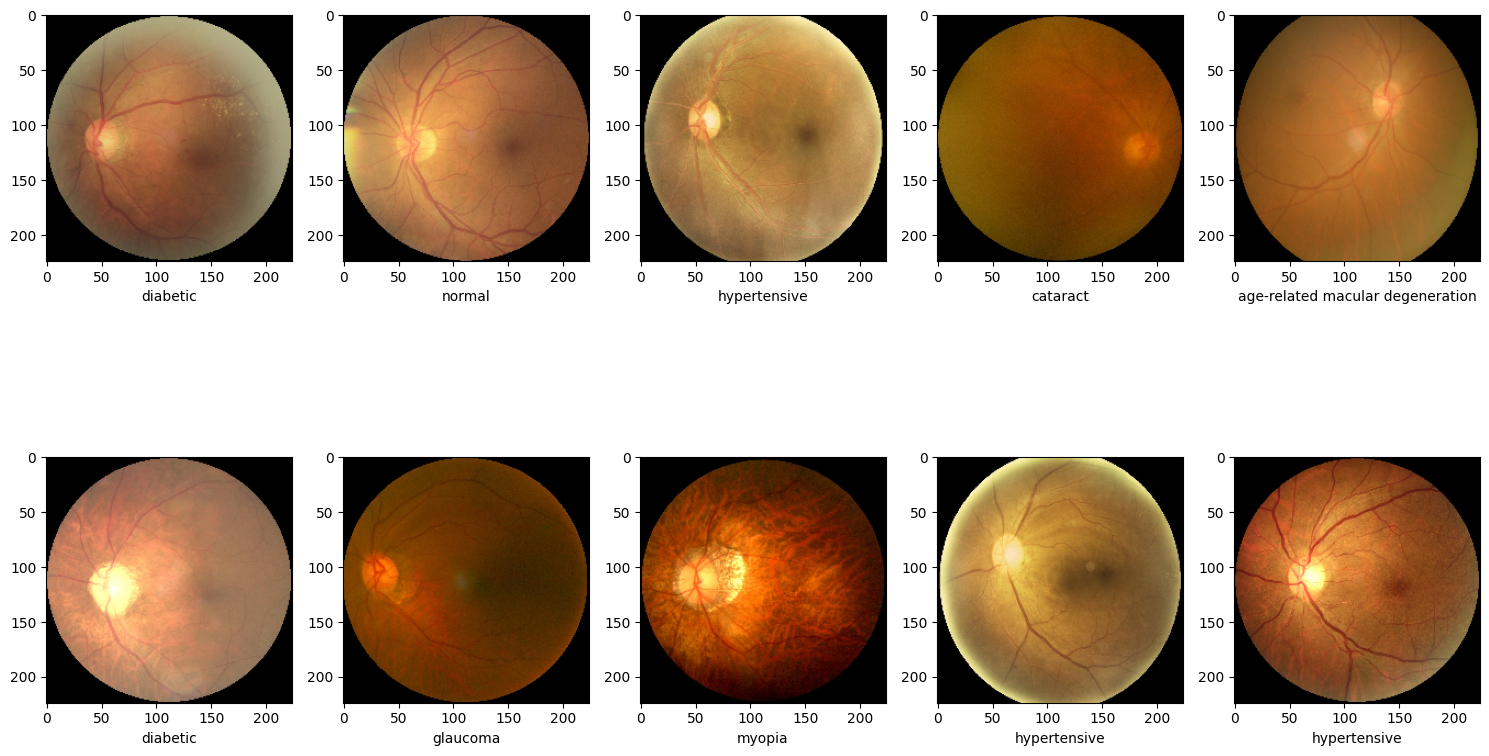

In [8]:
# Gantilah X dan y dengan variabel yang sesuai pada saat membuat dataset
plt.figure(figsize=(15, 10))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    label_id = dataset[sample][1]
    
    # Konversi label_id ke label yang sesuai
    labels = ['cataract', 'normal', 'diabetic', 'age-related macular degeneration', 'glaucoma', 'myopia', 'hypertensive']
    label = labels[label_id]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(label)

plt.tight_layout()
plt.show()

><h3>Dividing dataset into x(features) & y(target)</h3>

In [9]:
# # x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
# # y = np.array([i[1] for i in dataset])
from tensorflow.keras.utils import to_categorical
# Assuming num_classes is defined and set to 7
num_classes = len(class_images_dict)

# Convert labels to one-hot encoded format
y = np.array([i[1] for i in dataset])
y_onehot = to_categorical(y, num_classes=num_classes)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, normalize
# # # x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

# Split the dataset into training and testing sets
image_size=224
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
# x_train, x_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.3)

# import os
# import shutil
# import random
# from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical

# # Fungsi untuk membuat folder output
# def create_output_folders(output_folder, labels):
#     os.makedirs(output_folder, exist_ok=True)

#     # Hapus konten folder output jika ada
#     for label in labels:
#         label_folder = os.path.join(output_folder, label)
#         shutil.rmtree(label_folder, ignore_errors=True)
#         os.makedirs(label_folder, exist_ok=True)

# Split data menggunakan train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#Encode Y labels to 0, 1, 2, 3, then one hot encode. 
le = LabelEncoder()
le.fit(y_train)
y_train_deep = le.transform(y_train)
y_train_deep_cat = to_categorical(y_train_deep)

y_test_deep = le.transform(y_test)
y_test_deep_cat = to_categorical(y_test_deep)

# # Mengambil nama kelas dari labels
# class_names = [str(label) for label in range(num_classes)]

# # Folder untuk menyimpan gambar-gambar hasil konversi
# output_folder = "/kaggle/working/output/"

# # Membuat folder output jika belum ada
# os.makedirs(output_folder, exist_ok=True)

# # Membuat folder output untuk training dan testing
# train_output_folder = os.path.join(output_folder, 'train')
# test_output_folder = os.path.join(output_folder, 'test')
# create_output_folders(train_output_folder, class_names)
# create_output_folders(test_output_folder, class_names)

# # Menyimpan data training ke dalam folder
# for i in tqdm(range(len(x_train)), desc="Saving training data"):
#     img, label = x_train[i], y_train[i]
#     class_name = class_names[np.argmax(label)]
#     img_filename = f"{i}.png"  # Ganti dengan format nama file yang sesuai
#     img_path = os.path.join(train_output_folder, class_name, img_filename)
#     cv2.imwrite(img_path, img)

# # Menyimpan data testing ke dalam folder
# for i in tqdm(range(len(x_test)), desc="Saving testing data"):
#     img, label = x_test[i], y_test[i]
#     class_name = class_names[np.argmax(label)]
#     img_filename = f"{i}.png"  # Ganti dengan format nama file yang sesuai
#     img_path = os.path.join(test_output_folder, class_name, img_filename)
#     cv2.imwrite(img_path, img)

# print("Proses split dan penyimpanan data selesai.")


# # # Assuming x and y_onehot are your data and one-hot encoded labels
# # x_train, x_test, y_train_onehot, y_test_onehot = train_test_split(x, y_onehot, test_size=0.3)

# # # Convert one-hot encoded labels to categorical labels
# # y_train_labels = np.argmax(y_train_onehot, axis=1)
# # y_test_labels = np.argmax(y_test_onehot, axis=1)

# def preprocess_transformer_data(data):
#     # Sesuaikan dengan persiapan data yang dibutuhkan oleh model Transformer
#     # Contoh: Normalisasi, resizing, atau transformasi lainnya
    
#     # Misalnya, normalisasi data ke rentang [0, 1]
#     preprocessed_data = data / 255.0
    
#     return preprocessed_data

# # Assuming num_classes is defined and set to 7
# num_classes = len(class_images_dict)

# # Convert labels to one-hot encoded format
# y = np.array([i[1] for i in dataset])
# y_onehot = to_categorical(y, num_classes=num_classes)

# # Split the dataset into training and testing sets
# image_size = 224
# x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)

# # Split data into VGG and Transformer inputs
# x_train_vgg, x_test_vgg, y_train, y_test = train_test_split(x, y_onehot, test_size=0.3)

# # Assuming x_transformer is derived from x (modify this part based on your actual data)
# x_transformer = preprocess_transformer_data(x)  # Adjust based on your preprocessing function for the Transformer

><h3>Creating Model</h3>

In [11]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
# from tensorflow.keras.utils import to_categorical
# from sklearn.model_selection import train_test_split
# import datetime
# from tensorflow.keras.callbacks import TensorBoard
# import numpy as np
# import random

# # Assuming num_classes is defined and set to 7
# num_classes = 7

# # Convert labels to one-hot encoded format
# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)

# # Assuming image size is defined
# image_size = 224

# # Preprocess input data (VGG19-specific)
# x_train_preprocessed = preprocess_input(x_train)
# x_test_preprocessed = preprocess_input(x_test)

# # Create your model architecture
# def create_model(input_shape, num_classes):
#     vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    
#     for layer in vgg.layers:
#         layer.trainable = False
    
#     model = Sequential()
#     model.add(vgg)
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dropout(0.25))
#     model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
#     model.add(BatchNormalization())
#     model.add(Dense(num_classes, activation="softmax"))
    
#     optimizer = Adam(learning_rate=0.01)
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model

# # Define callbacks
# checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
# earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# # Create and compile the model
# model = create_model((image_size, image_size, 3), num_classes)

# # Train the model
# history = model.fit(x_train_preprocessed, y_train_onehot, validation_data=(x_test_preprocessed, y_test_onehot),
#                     epochs=50, batch_size=32, callbacks=[checkpoint, earlystop, reduce_lr])

# # Evaluate the model
# loss, accuracy = model.evaluate(x_test_preprocessed, y_test_onehot)
# print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# # Define your model architecture (as you provided)
# def create_model(input_shape, num_classes):
#     vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
    
#     for layer in vgg.layers:
#         layer.trainable = False
    
#     model = Sequential()
#     model.add(vgg)
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dropout(0.25))
#     model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
#     model.add(BatchNormalization())
#     model.add(Dense(num_classes, activation="softmax"))
    
# #     model.summary()

#     optimizer = Adam(learning_rate=0.01)
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model

# # Load your data and create datasets
# # Assuming x_train, y_train, x_test, y_test are already defined

# # Assuming num_classes is defined and set to 7
# num_classes = 7

# # Convert labels to one-hot encoded format
# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)

# # Assuming image size is defined
# image_size = 224

# # Create multiple instances of the model
# num_models = 5  # You can adjust the number of models based on your preference
# models = [create_model((image_size, image_size, 3), num_classes) for _ in range(num_models)]

# # Training each model independently
# histories = []
# for i, model in enumerate(models):
#     print(f"Training Model {i + 1}")
    
#     checkpoint = ModelCheckpoint(f'model_{i + 1}.h5', monitor='val_loss', save_best_only=True, verbose=1,
#                                  save_weights_only=False, period=1)
#     earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
#     lr_scheduler = LearningRateScheduler(lambda epoch: 0.01 if epoch > 10 else (0.1 if epoch > 5 else 1.0))

#     history = model.fit(x_train, y_train_onehot, steps_per_epoch=len(x_train) / 32, batch_size=32, epochs=50,
#                         validation_data=(x_test, y_test_onehot), verbose=1, callbacks=[checkpoint, earlystop, lr_scheduler])
    
#     histories.append(history)

# # Combine logits (predictions before softmax) from all models
# ensemble_logits = np.zeros_like(y_test_onehot)
# for model in models:
#     ensemble_logits += model.predict(x_test, logits=True)  # Ensure your model has logits=True

# # Average logits from all models
# ensemble_logits /= num_models

# # Convert logits to probabilities using softmax
# ensemble_predictions_prob = softmax(ensemble_logits, axis=1)

# print(f"Ensemble Model - Loss: {ensemble_loss:.4f}, Accuracy: {ensemble_accuracy * 100:.2f}%")

In [12]:
# import datetime
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
# from tensorflow.keras.models import Model
# from tensorflow.keras import layers, models
# from tensorflow.keras.layers import Input, concatenate
# from tensorflow.keras import Sequential
# from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
# from keras import applications, regularizers
# from keras.optimizers import Adam

# def linear_projection_block(x, output_dim):
#     x = layers.Dense(output_dim)(x)
#     return x

# def patch_position_embedding(x):
#     cls_token = layers.Lambda(lambda x: x[:, 0:1, :])(x)  # Extract CLS token
#     position_embedding = layers.Lambda(lambda x: x[:, 1:, :])(x)  # Extract position embedding
#     x = layers.Concatenate(axis=1)([cls_token, position_embedding])
#     return x

# def transformer_encoder_block(x, num_heads, ff_dim, dropout_rate=0.1):
#     # Implementation of your Transformer Encoder Block
#     # You can use the transformer encoder implementation from libraries like TensorFlow or Hugging Face Transformers
#     # Here's a simplified version:
#     # For example:
#     # x = TransformerEncoderLayer(num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)(x)
#     return x

# def grading_prediction_block(x, num_classes):
#     class_features = []
    
#     # Generate multiple class features
#     for _ in range(num_classes):
#         class_feature = layers.Conv2D(1, (1, 1), activation='relu')(x)
#         class_feature = layers.Flatten()(class_feature)
#         class_features.append(class_feature)

#     # Fuse class features by average pooling
#     fused_features = layers.Average()(class_features)

#     # Classification result through an FC classifier
#     classification_result = layers.Dense(num_classes, activation='softmax')(fused_features)

#     return classification_result


# # Fungsi pembuatan model Transformer
# def create_model(input_shape, num_heads, ff_dim, num_classes, output_dim, L):
#     # Input
#     input_layer = layers.Input(shape=input_shape)

#     # Feature Extraction Block (FEB)
#     linear_projection = linear_projection_block(input_layer, output_dim)
#     patch_position_embedded = patch_position_embedding(linear_projection)
    
#     # Transformer Encoder Block (Repeat stacking L times)
#     for _ in range(L):
#         transformer_output = transformer_encoder_block(patch_position_embedded, num_heads, ff_dim)

#     # Grading Prediction Block
#     classification_result = grading_prediction_block(transformer_output, num_classes)

#     # Model
#     model = models.Model(inputs=input_layer, outputs=classification_result)

#     return model

# # Fungsi untuk menggabungkan model VGG19 dan model Transformer
# def combine_models(vgg_model, transformer_model, num_classes):
#     # Get the output layer of the VGG model
#     vgg_output = vgg_model.layers[-2].output

#     # Get the output layer of the Transformer model
#     transformer_output = transformer_model.layers[-1].output

#     # Menggabungkan output dari kedua model
#     combined_output = concatenate([vgg_output, transformer_output])

#     # Tambahkan lapisan Dense untuk prediksi kelas
#     x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(combined_output)
#     x = BatchNormalization()(x)
#     x = Dropout(0.25)(x)
#     x = Dense(num_classes, activation='softmax')(x)

#     # Gabungkan input dan output menjadi model gabungan
#     combined_model = Model(inputs=[vgg_model.input, transformer_model.input], outputs=x)

#     return combined_model

# # Fungsi pembuatan model VGG19
# def create_vgg19_model(input_shape, num_classes):
#     vgg = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)

#     # Menghentikan pelatihan VGG19
#     for layer in vgg.layers:
#         layer.trainable = False

#     # Membangun model
#     x = Flatten()(vgg.output)
#     x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.25)(x)
#     x = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=vgg.input, outputs=x)

#     return model

# # Inisialisasi parameter
# input_shape_vgg = (224, 224, 3)
# num_heads = 8
# ff_dim = 512
# num_classes = 7
# output_dim = 256
# L = 3

# # Membuat model VGG19 dan Transformer
# input_shape_transformer = (224, 224, 3)  # Sesuaikan dengan bentuk input Transformer
# vgg_model = create_vgg19_model(input_shape_vgg, num_classes)
# transformer_model = create_model(input_shape_transformer, num_heads, ff_dim, num_classes, output_dim, L)

# # Membuat model gabungan
# combined_model = combine_models(vgg_model, transformer_model, num_classes)

# # Menampilkan ringkasan model gabungan
# combined_model.summary()

# # Split data
# x_train_vgg, x_test_vgg, x_train_transformer, x_test_transformer, y_train, y_test = train_test_split(
#     x, x_transformer, y_onehot, test_size=0.3
# )

# # Kompilasi model gabungan
# optimizer = Adam(learning_rate=0.01)
# combined_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# checkpoint_combined = ModelCheckpoint('model_combined.save', monitor='val_loss', save_best_only=True, verbose=1, save_weights_only=False, period=1)
# earlystop_combined = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# log_dir_combined = "logs/fit_combined/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback_combined = TensorBoard(log_dir=log_dir_combined, histogram_freq=1)

# # Learning Rate Schedule
# def lr_schedule_combined(epoch):
#     lr = 0.01
#     if epoch > 10:
#         lr *= 0.1
#     elif epoch > 5:
#         lr *= 0.5
#     return lr

# lr_scheduler_combined = LearningRateScheduler(lr_schedule_combined)

# # Train the combined model
# history_combined = combined_model.fit(
#     [x_train_vgg, x_train_transformer], y_train,
#     steps_per_epoch=len(x_train_vgg) / 128, batch_size=128,
#     epochs=15, validation_data=([x_test_vgg, x_test_transformer], y_test),
#     verbose=1, callbacks=[checkpoint_combined, earlystop_combined, lr_scheduler_combined, tensorboard_callback_combined]
# )

In [13]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 [==============================] - 4s 0us/step


In [14]:
for layer in vgg.layers:
    layer.trainable = False

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from keras import applications, regularizers
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
# model = Sequential()
# model.add(vgg)
# model.add(Flatten())
# model.add(Dense(7,activation="sigmoid"))
# Definisikan parameter untuk pelatihan model

num_classes = 7

model = Sequential()
model.add(vgg)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(num_classes,activation="softmax"))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 256)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dropout (Dropout)           (None, 2304)              0         
                                                        

In [17]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning Rate Schedule
def lr_schedule(epoch):
    lr = 0.01
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

In [18]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
# checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_loss",verbose=1,save_best_only=True,
#                              save_weights_only=False,period=1)
# earlystop = EarlyStopping(monitor="val_loss",patience=5,verbose=1)

checkpoint = ModelCheckpoint('model_vgg19.save', monitor='val_loss', save_best_only=True, verbose=1,save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
log_dir = "logs/fit_vgg/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
input_shape = (224, 224, 3)

# # Membuat objek ImageDataGenerator tanpa augmentasi
# datagen = ImageDataGenerator(rescale=1./255)

# # Menggunakan flow_from_directory untuk mendapatkan data training dan testing
# train_generator = datagen.flow_from_directory(
#     train_output_folder,
#     target_size=(input_shape[0], input_shape[1]),
#     batch_size=32,
#     class_mode='categorical'
# )

# test_generator = datagen.flow_from_directory(
#     test_output_folder,
#     target_size=(input_shape[0], input_shape[1]),
#     batch_size=32,
#     class_mode='categorical'
# )

# from sklearn.utils.class_weight import compute_class_weight

# # Assuming you already have y_train_deep as integer-encoded class labels

# # Calculate class weights
# class_weights = compute_class_weight('balanced', np.unique(y_train_deep), y_train_deep)

# # Convert class weights to a dictionary
# class_weights_dict = dict(zip(np.unique(y_train_deep), class_weights))

history = model.fit(x_train, y_train_deep_cat, epochs=50, validation_data = (x_test, y_test_deep_cat),
                   verbose=1, callbacks=[checkpoint,earlystop, lr_scheduler])

# # Melatih model
# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     epochs=15,
#     validation_data=test_generator,
#     validation_steps=len(test_generator),
#     verbose=1,
#     callbacks=[checkpoint,earlystop, lr_scheduler]
# )

# history = model.fit(x_train,y_train,steps_per_epoch=len(x_train) / 128, batch_size=128,epochs=15,validation_data=(x_test,y_test),
#                     verbose=1,callbacks=[checkpoint,earlystop, lr_scheduler])

# from sklearn.utils.class_weight import compute_sample_weight

# # Calculate class weights
# sample_weights = compute_sample_weight('balanced', y_train_labels)

# # Convert class weights to a dictionary
# class_weight_dict = dict(zip(np.unique(y_train_labels), sample_weights))

# # Use class weights in model.fit
# history = model.fit(x_train, y_train, steps_per_epoch=len(x_train) / 32, batch_size=32, epochs=15, validation_data=(x_test, y_test),
#                     class_weight=class_weight_dict, verbose=1, callbacks=[checkpoint, earlystop, lr_scheduler])

Epoch 1/50
871/871 [==============================] - ETA: 0s - loss: 2.2976 - accuracy: 0.5221
Epoch 1: val_loss improved from inf to 4.24222, saving model to model_vgg19.save
871/871 [==============================] - 112s 121ms/step - loss: 2.2976 - accuracy: 0.5221 - val_loss: 4.2422 - val_accuracy: 0.2937 - lr: 0.0100
Epoch 2/50
870/871 [============================>.] - ETA: 0s - loss: 5.9983 - accuracy: 0.7561
Epoch 2: val_loss did not improve from 4.24222
871/871 [==============================] - 95s 109ms/step - loss: 5.9987 - accuracy: 0.7559 - val_loss: 4.4586 - val_accuracy: 0.4596 - lr: 0.0100
Epoch 3/50
870/871 [============================>.] - ETA: 0s - loss: 4.4714 - accuracy: 0.8430
Epoch 3: val_loss did not improve from 4.24222
871/871 [==============================] - 95s 109ms/step - loss: 4.4715 - accuracy: 0.8429 - val_loss: 4.5894 - val_accuracy: 0.2559 - lr: 0.0100
Epoch 4/50
870/871 [============================>.] - ETA: 0s - loss: 3.1908 - accuracy: 0.8916

In [20]:
# loss,accuracy = model.evaluate(x_test,y_test)
# print("loss:",loss)
# print("Accuracy:",accuracy)

# prediction_deep = model.predict(X_test_deep)
# evaluate the keras model
loss, accuracy = model.evaluate(x_test, y_test_deep_cat, verbose=0)
print('Loss: %.2f' % (loss*100))
print('Accuracy: %.2f' % (accuracy*100))

# # Evaluasi model
# test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
# print(f"Test Accuracy: {test_acc * 100:.2f}%")

Loss: 96.61
Accuracy: 75.00


In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# y_pred = model.predict_classes(x_test)

# # Assuming model.predict returns probabilities for each class
# y_pred_prob = model.predict(x_test)

# # Convert probabilities to class labels (use argmax along axis 1)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # If y_test is one-hot encoded, convert it back to class labels
# y_test_labels = np.argmax(y_test, axis=1)

# print("Shape of y_test_labels:", y_test_labels.shape)
# print("Shape of y_pred:", y_pred.shape)

# # Menggunakan model untuk melakukan prediksi
# y_pred_prob = model.predict(test_generator)

# # Convert probabilities to class labels (use argmax along axis 1)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Assuming model.predict returns probabilities for each class
# y_pred_prob = model.predict(test_generator)

# # Convert probabilities to class labels (use argmax along axis 1)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Extract true labels from the test generator
# y_test_labels = test_generator.classes

In [22]:
# model.save("eyedisease.save")

In [23]:
# # accuracy_score(y_test,y_pred)

# from sklearn.metrics import accuracy_score
# from mlxtend.plotting import plot_confusion_matrix
# import seaborn as sns

# # Prediksi menggunakan model pada data test (asumsi Anda memiliki X_test_deep dan y_test_deep_cat)
# y_pred_prob = model.predict(x_test)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Hitung akurasi
# accuracy = accuracy_score(y_test_deep_cat.argmax(axis=1), y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Tampilkan classification report
# print("Classification Report:")
# print(classification_report(y_test_deep_cat.argmax(axis=1), y_pred))

# # Tampilkan confusion matrix
# print("Confusion Matrix:")
# cm = confusion_matrix(y_test_deep_cat.argmax(axis=1), y_pred)
# print(cm)

# class_names = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]  # Ganti dengan kata kunci yang diinginkan

# # Visualisasi confusion matrix menggunakan seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# # Calculate accuracy
# accuracy = accuracy_score(y_test_labels, y_pred)
# print(f'Accuracy: {accuracy}')

# # Ambil true labels dari test_generator
# y_true = test_generator.classes

# # Hitung akurasi
# accuracy = accuracy_score(y_true, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")

# # Tampilkan classification report
# print("Classification Report:")
# print(classification_report(y_true, y_pred))

# # Tampilkan confusion matrix
# print("Confusion Matrix:")
# cm = confusion_matrix(test_generator.classes, y_pred)
# print(cm)

# class_names = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]  # Ganti dengan kata kunci yang diinginkan

# # Visualisasi confusion matrix menggunakan seaborn
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# # Plot confusion matrix using seaborn
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Display classification report
# print(classification_report(y_test_labels_encoded, y_pred_encoded, target_names=class_names))

In [24]:
# print(classification_report(y_test,y_pred))

# # Assuming y_test_labels and y_pred are available
# print(classification_report(y_test_labels, y_pred))

In [25]:
# from mlxtend.plotting import plot_confusion_matrix
# from sklearn.preprocessing import LabelEncoder
# import seaborn as sns
# # cm = confusion_matrix(y_test,y_pred)
# # plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
# #                       show_normed = True);


# # Assuming y_test_labels and y_pred are available
# le = LabelEncoder()
# y_test_labels_encoded = le.fit_transform(y_test_labels)
# y_pred_encoded = le.transform(y_pred)

# # Calculate confusion matrix
# cm = confusion_matrix(y_test_labels_encoded, y_pred_encoded)
# class_names = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]  # Ganti dengan kata kunci yang diinginkan

# # Plot confusion matrix using seaborn
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Display classification report
# print(classification_report(y_test_labels_encoded, y_pred_encoded, target_names=class_names))

><h3>Learning Curve</h3>

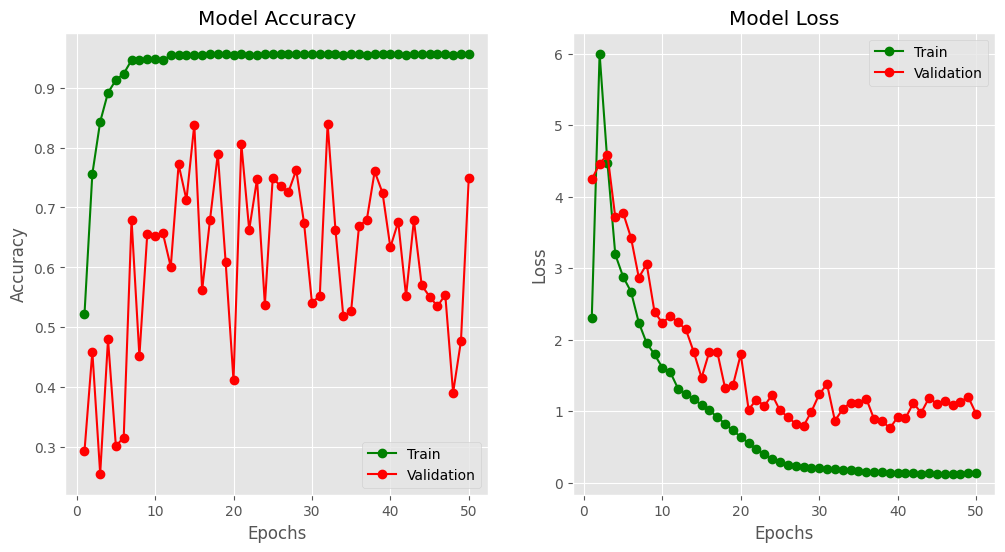

In [26]:
# plt.style.use("ggplot")
# fig = plt.figure(figsize=(12,6))
# epochs = range(1,16)
# plt.subplot(1,2,1)
# plt.plot(epochs,history.history["accuracy"],"go-")
# plt.plot(epochs,history.history["val_accuracy"],"ro-")
# plt.title("Model Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(["Train","val"],loc = "upper left")

# plt.subplot(1,2,2)
# plt.plot(epochs,history.history["loss"],"go-")
# plt.plot(epochs,history.history["val_loss"],"ro-")
# plt.title("Model Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(["Train","val"],loc = "upper left")
# plt.show()

plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))

# Extract the actual number of epochs from the training history
epochs = range(1, len(history.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")

plt.show()

373/373 [==============================] - 27s 72ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1664
           1       1.00      0.78      0.88      1712
           2       0.89      0.60      0.72      1703
           3       0.67      0.99      0.80      1661
           4       0.60      0.07      0.12      1740
           5       0.99      0.96      0.98      1725
           6       0.45      0.90      0.60      1730

    accuracy                           0.75     11935
   macro avg       0.80      0.75      0.72     11935
weighted avg       0.80      0.75      0.72     11935

Confusion Matrix:
[[1598    0    0   66    0    0    0]
 [   6 1339    9  289   28   10   31]
 [   0    0 1025  265    0    0  413]
 [   9    0    0 1652    0    0    0]
 [   6    0   38  101  116    0 1479]
 [  18    0    0    2   49 1656    0]
 [   0    0   82   83    0    0 1565]]


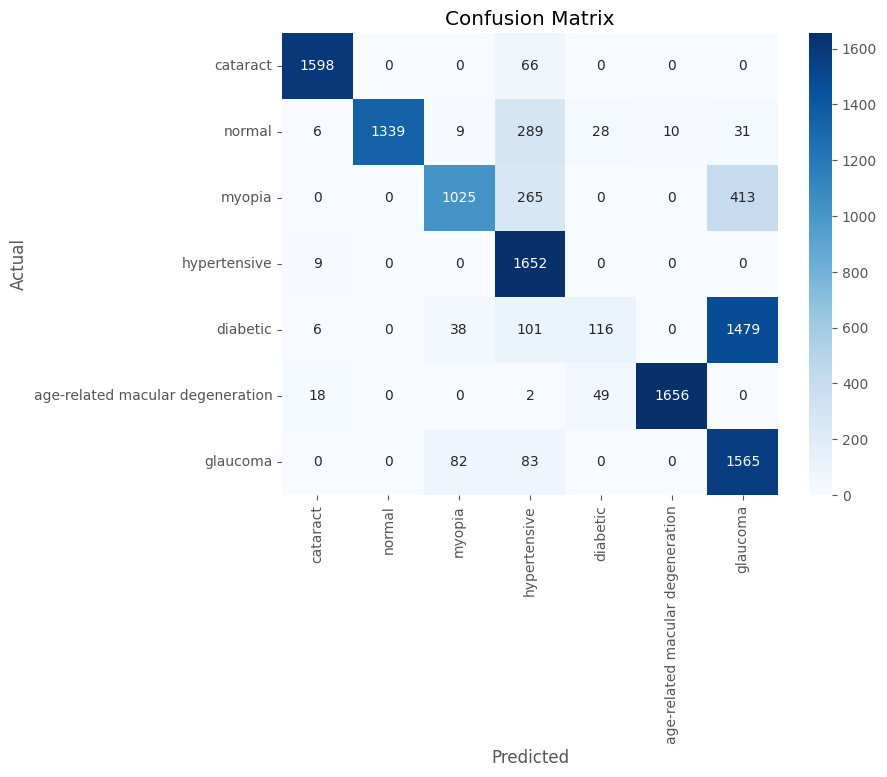


Class 0 (cataract):
  AUC-ROC: 0.9986
  Precision: 0.9762
  Recall: 0.9603
  Specificity: 0.9962
  F1-score: 0.9682
  Accuracy: 0.9912

Class 1 (normal):
  AUC-ROC: 0.9789
  Precision: 1.0000
  Recall: 0.7821
  Specificity: 1.0000
  F1-score: 0.8777
  Accuracy: 0.9687

Class 2 (myopia):
  AUC-ROC: 0.9877
  Precision: 0.8882
  Recall: 0.6019
  Specificity: 0.9874
  F1-score: 0.7175
  Accuracy: 0.9324

Class 3 (hypertensive):
  AUC-ROC: 0.9847
  Precision: 0.6721
  Recall: 0.9946
  Specificity: 0.9215
  F1-score: 0.8021
  Accuracy: 0.9317

Class 4 (diabetic):
  AUC-ROC: 0.8467
  Precision: 0.6010
  Recall: 0.0667
  Specificity: 0.9924
  F1-score: 0.1200
  Accuracy: 0.8575

Class 5 (age-related macular degeneration):
  AUC-ROC: 0.9988
  Precision: 0.9940
  Recall: 0.9600
  Specificity: 0.9990
  F1-score: 0.9767
  Accuracy: 0.9934

Class 6 (glaucoma):
  AUC-ROC: 0.9590
  Precision: 0.4487
  Recall: 0.9046
  Specificity: 0.8116
  F1-score: 0.5998
  Accuracy: 0.8251


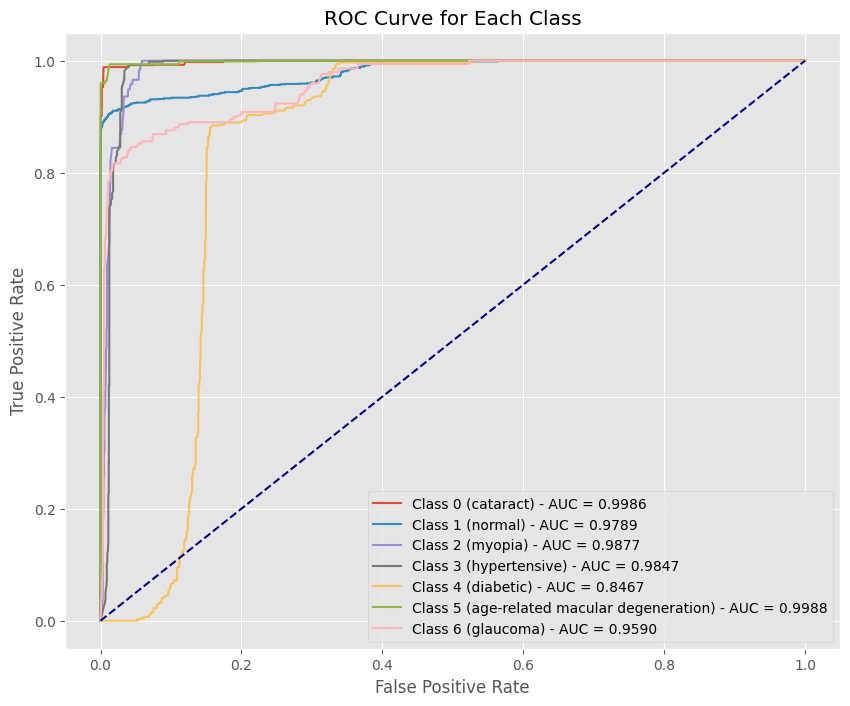

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

# Ambil true labels dari y_test_deep_cat (tidak one-hot encoded)
y_true = np.argmax(y_test_deep_cat, axis=1)

# Prediksi probabilitas menggunakan model pada data test
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Tampilkan classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Tampilkan confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

class_names = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]

# Visualisasi confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Kalkulasi dan tampilkan AUC-ROC serta metrics untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

precision = dict()
recall = dict()
specificity = dict()
f1_score = dict()
accuracy = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i] = precision_score(y_true == i, y_pred == i)
    recall[i] = recall_score(y_true == i, y_pred == i)
    
    tn, fp, fn, tp = confusion_matrix(y_true == i, y_pred == i).ravel()
    specificity[i] = tn / (tn + fp)
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    accuracy[i] = accuracy_score(y_true == i, y_pred == i)

    print(f"\nClass {i} ({class_names[i]}):")
    print(f"  AUC-ROC: {roc_auc[i]:.4f}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  Specificity: {specificity[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")
    print(f"  Accuracy: {accuracy[i]:.4f}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ({class_names[i]}) - AUC = {roc_auc[i]:.4f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

><h3>Prediction:</h3>

In [28]:
# from tensorflow.keras.applications.vgg19 import preprocess_input
# # plt.figure(figsize=(12,7))
# # for i in range(10):
# #     sample = random.choice(range(len(x_test)))
# #     image = x_test[sample]
# #     category = y_test[sample]
# #     pred_category = y_pred[sample]
    
# #     if category== 0:
# #         label = "Normal"
# #     else:
# #         label = "Cataract"      
# #     if pred_category== 0:
# #         pred_label = "Normal"
# #     else:
# #         pred_label = "Cataract"   
# #     plt.subplot(2,5,i+1)
# #     plt.imshow(image)
# #     plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
# # plt.tight_layout() 

# def prediksi(image):
#     output = {0: 'cataract', 1: 'normal', 2: 'diabetic', 3: 'age-related macular degeneration',
#               4: 'glaucoma', 5: 'myopia', 6: 'hypertensive'}
    
#     # Preprocess the input image
# #     rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# #     rbg = cv2.resize(rgb, (image_size, image_size))
#     image = load_prep_img(image)
#     image = histogram_equalization(image)
#     input_image = np.expand_dims(image, axis=0)  # Add batch dimension
#     input_image = preprocess_input(input_image)  # Preprocess the input (if necessary)

#     # Perform prediction using the combined model
#     predictions = model.predict([np.array([input_image]), np.array([input_image])])  # Assuming VGG and Transformer both take the same input

#     # Get the predicted class and confidence
#     predicted_class = output[np.argmax(predictions)]
#     confidence = np.max(predictions) * 100

#     return predicted_class, confidence

# plt.figure(figsize=(15, 10))

# # Select a random sample of images
# for i in range(10):
#     sample_index = random.choice(range(len(x_test)))
#     image = x_test[sample_index]
#     actual_category = class_names[np.argmax(y_test[sample_index])]  # Convert one-hot encoded to class name

#     pred_category, confidence = prediksi(image)

#     plt.subplot(2, 5, i + 1)
#     plt.imshow(image)
#     plt.title("Actual: {}\nPrediction: {}\nConfidence: {:.2f}%".format(actual_category, pred_category, confidence))
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

In [29]:
# # Map class indices to class names for binary classification
# class_names_binary = {0: 'cataract', 1: 'normal'}

# plt.figure(figsize=(15, 10))

# # Select a random sample of images from 'cataract' and 'normal' classes only
# for i in range(10):
#     # Get indices of 'cataract' and 'normal' classes
#     cataract_indices = np.where(y_test[:, 0] == 1)[0]
#     normal_indices = np.where(y_test[:, 1] == 1)[0]

#     # Combine the indices
#     all_indices = np.concatenate([cataract_indices, normal_indices])

#     # Select a random index from the combined indices
#     sample_index = random.choice(all_indices)

#     image = x_test[sample_index]
#     actual_category = class_names[np.argmax(y_test[sample_index])]  # Convert one-hot encoded to class name

#     # Ensure that the input image has the correct shape
#     input_image = np.expand_dims(image, axis=0)  # Add batch dimension
#     input_image = preprocess_input(input_image)  # Preprocess the input (if necessary)

#     pred_category_probs = model.predict(input_image)[0]  # Prediction probabilities for all classes

#     # Convert to binary classification (0 or 1)
#     binary_prediction = 1 if np.argmax(pred_category_probs) in [0, 1] else 0
    
#     # Select the top predicted class for binary classification
#     pred_category = class_names_binary[binary_prediction]

#     plt.subplot(2, 5, i + 1)
#     plt.imshow(image)
#     plt.title("Actual: {}\nPrediction: {}".format(actual_category, pred_category))
#     plt.axis('off')

#     # Perform prediction using the modified prediksi function for binary classification
#     predicted_class, confidence = prediksi(image)
#     print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

# plt.tight_layout()
# plt.show()

In [30]:
# # Map class indices to class names for binary classification
# class_names_binary = {0: 'normal', 1: 'myopia'}

# plt.figure(figsize=(15, 10))

# # Select a random sample of images from 'normal' and 'myopia' classes only
# for i in range(10):
#     # Get indices of 'normal' and 'myopia' classes
#     normal_indices = np.where(y_test[:, 1] == 1)[0]
#     myopia_indices = np.where(y_test[:, 5] == 1)[0]

#     # Combine the indices
#     all_indices = np.concatenate([normal_indices, myopia_indices])

#     # Select a random index from the combined indices
#     sample_index = random.choice(all_indices)

#     image = x_test[sample_index]
#     actual_category = class_names[np.argmax(y_test[sample_index])]  # Convert one-hot encoded to class name

#     # Ensure that the input image has the correct shape
#     input_image = np.expand_dims(image, axis=0)  # Add batch dimension
#     input_image = preprocess_input(input_image)  # Preprocess the input (if necessary)

#     pred_category_probs = model.predict(input_image)[0]  # Prediction probabilities for all classes

#     # Convert to binary classification (0 or 1)
#     binary_prediction = 1 if np.argmax(pred_category_probs) in [1, 5] else 0
    
#     # Select the top predicted class for binary classification
#     pred_category = class_names_binary[binary_prediction]

#     plt.subplot(2, 5, i + 1)
#     plt.imshow(image)
#     plt.title("Actual: {}\nPrediction: {}".format(actual_category, pred_category))
#     plt.axis('off')

#     # Perform prediction using the modified prediksi function for binary classification
#     predicted_class, confidence = prediksi(image)
#     print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

# plt.tight_layout()
# plt.show()

In [31]:
# # Map class indices to class names for ternary classification
# class_names_ternary = {0: 'normal', 1: 'cataract', 2: 'myopia'}

# plt.figure(figsize=(15, 10))

# # Select a random sample of images from 'normal', 'cataract', and 'myopia' classes only
# for i in range(10):
#     # Get indices of 'normal', 'cataract', and 'myopia' classes
#     normal_indices = np.where(y_test[:, 1] == 1)[0]
#     cataract_indices = np.where(y_test[:, 0] == 1)[0]
#     myopia_indices = np.where(y_test[:, 5] == 1)[0]

#     # Combine the indices
#     all_indices = np.concatenate([normal_indices, cataract_indices, myopia_indices])

#     # Select a random index from the combined indices
#     sample_index = random.choice(all_indices)

#     image = x_test[sample_index]
#     actual_category = class_names[np.argmax(y_test[sample_index])]  # Convert one-hot encoded to class name

#     # Ensure that the input image has the correct shape
#     input_image = np.expand_dims(image, axis=0)  # Add batch dimension
#     input_image = preprocess_input(input_image)  # Preprocess the input (if necessary)

#     pred_category_probs = model.predict(input_image)[0]  # Prediction probabilities for all classes

#     # Convert to ternary classification (0, 1, or 2)
#     ternary_prediction = np.argmax(pred_category_probs)
    
#     # Check if the ternary_prediction is valid
#     if ternary_prediction in class_names_ternary:
#         pred_category = class_names_ternary[ternary_prediction]
#     else:
#         pred_category = "Unknown"

#     plt.subplot(2, 5, i + 1)
#     plt.imshow(image)
#     plt.title("Actual: {}\nPrediction: {}".format(actual_category, pred_category))
#     plt.axis('off')

#     # Perform prediction using the modified prediksi function for ternary classification
#     predicted_class, confidence = prediksi(image)
#     print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")

# plt.tight_layout()
# plt.show()

In [32]:
sample_index = random.choice(range(len(y_test_deep)))
image = x_test[sample_index]
actual_category = class_names[np.argmax(y_test_deep[sample_index])]
pred_category_probs = model.predict(np.expand_dims(image, axis=0))[0]
predicted_category = class_names[np.argmax(pred_category_probs)]

print("Actual Category:", actual_category)
print("Predicted Category:", predicted_category)

1/1 [==============================] - 0s 314ms/step
Actual Category: cataract
Predicted Category: age-related macular degeneration
